In [1]:
import torch
import os
import numpy as np
import torchvision as tv
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
%matplotlib inline

In [2]:
resnet18 = models.resnet18()
print(resnet18)
vgg16 = models.vgg16()
print(vgg16)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
data_transforms = {
    "train": transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
    ]),
    "val": transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
    ]),
}

BATCH_SIZE = 12

data_dir = "/content/drive/MyDrive/Colab Notebooks/hymenoptera_data"

image_datasets = {key: datasets.ImageFolder(os.path.join(data_dir, key), data_transforms[key]) for key in data_transforms.keys()}
dataset_sizes = {key: len(val) for key, val in image_datasets.items()}
class_names = image_datasets['train'].classes
data_loaders = {key: torch.utils.data.DataLoader(image_datasets[key], batch_size=BATCH_SIZE, shuffle=True) for key in data_transforms.keys()}


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Text(0.5, 1.0, "['ants', 'ants', 'bees', 'ants', 'bees', 'ants', 'bees', 'ants', 'bees', 'bees', 'ants', 'bees']")

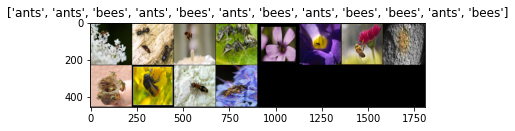

In [70]:
inputs, classes = next(iter(data_loaders['train']))
out = tv.utils.make_grid(inputs)
out = out.numpy().transpose((1, 2, 0))
plt.imshow(out)
plt.title([class_names[key] for key in classes])

In [71]:
def train(model, loss, optimizer, num_epochs=5):
  for epoch in range(num_epochs):
    print("Epoch {}/{}: ".format(epoch + 1, num_epochs))

    model.train()
    train_loss, train_acc = 0, 0
    for X, y in data_loaders["train"]:
      X = X.to(device)
      y = y.to(device)

      optimizer.zero_grad()
      y_pred = model(X)
      _, preds = torch.max(y_pred, 1)
      l = loss(y_pred, y)
      l.backward()
      optimizer.step()
      train_loss += l.item() * X.size(0)
      train_acc += torch.sum(preds == y.data)
    
    epoch_loss = train_loss / dataset_sizes["train"]
    epoch_acc = train_acc / dataset_sizes["train"]
    print('train_loss: {:.4f}, train_acc: {:.4f}'.format(epoch_loss, epoch_acc))

    model.eval()
    test_loss, test_acc = 0, 0
    for X, y in data_loaders["val"]:
      X = X.to(device)
      y = y.to(device)

      y_pred = model(X)
      l = loss(y_pred, y)
      _, preds = torch.max(y_pred, 1)

      test_loss += l.item() * X.size(0)
      test_acc += torch.sum(preds == y.data)
    
    epoch_loss = test_loss / dataset_sizes["val"]
    epoch_acc = test_acc / dataset_sizes["val"]
    print('test_loss: {:.4f}, test_acc: {:.4f}'.format(epoch_loss, epoch_acc))
    print("-" * 80)
    print("")

# Обучение модели ResNet 18 и VGG 16 с нуля

In [72]:
resnet18 = models.resnet18()
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 2)
resnet18 = resnet18.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
train(resnet18, loss, optimizer, 5)

Epoch 1/5: 
train_loss: 0.7035, train_acc: 0.5369
test_loss: 0.6920, test_acc: 0.4967
--------------------------------------------------------------------------------

Epoch 2/5: 
train_loss: 0.6317, train_acc: 0.6557
test_loss: 0.7422, test_acc: 0.5359
--------------------------------------------------------------------------------

Epoch 3/5: 
train_loss: 0.5604, train_acc: 0.6844
test_loss: 0.6591, test_acc: 0.6797
--------------------------------------------------------------------------------

Epoch 4/5: 
train_loss: 0.5422, train_acc: 0.7213
test_loss: 0.7056, test_acc: 0.6405
--------------------------------------------------------------------------------

Epoch 5/5: 
train_loss: 0.5366, train_acc: 0.7500
test_loss: 0.5753, test_acc: 0.7255
--------------------------------------------------------------------------------



In [82]:
model = models.vgg16()
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2)
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, loss, optimizer, 5)

Epoch 1/5: 
train_loss: 0.6979, train_acc: 0.4590
test_loss: 0.6909, test_acc: 0.6536
--------------------------------------------------------------------------------

Epoch 2/5: 
train_loss: 0.6933, train_acc: 0.4836
test_loss: 0.6936, test_acc: 0.4575
--------------------------------------------------------------------------------

Epoch 3/5: 
train_loss: 0.6918, train_acc: 0.4836
test_loss: 0.6879, test_acc: 0.5490
--------------------------------------------------------------------------------

Epoch 4/5: 
train_loss: 0.6890, train_acc: 0.5738
test_loss: 0.6899, test_acc: 0.5098
--------------------------------------------------------------------------------

Epoch 5/5: 
train_loss: 0.6882, train_acc: 0.5492
test_loss: 0.6868, test_acc: 0.6536
--------------------------------------------------------------------------------



# FineTuning

In [83]:
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False

resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 2)
resnet18 = resnet18.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9)
train(resnet18, loss, optimizer, 5)

Epoch 1/5: 
train_loss: 0.6326, train_acc: 0.6393
test_loss: 0.4028, test_acc: 0.8170
--------------------------------------------------------------------------------

Epoch 2/5: 
train_loss: 0.3872, train_acc: 0.8279
test_loss: 0.2840, test_acc: 0.8954
--------------------------------------------------------------------------------

Epoch 3/5: 
train_loss: 0.2721, train_acc: 0.8893
test_loss: 0.2864, test_acc: 0.8889
--------------------------------------------------------------------------------

Epoch 4/5: 
train_loss: 0.2547, train_acc: 0.9098
test_loss: 0.2379, test_acc: 0.9020
--------------------------------------------------------------------------------

Epoch 5/5: 
train_loss: 0.1788, train_acc: 0.9508
test_loss: 0.2187, test_acc: 0.9281
--------------------------------------------------------------------------------



In [84]:
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
  
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2)
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)
train(model, loss, optimizer, 5)

Epoch 1/5: 
train_loss: 0.4619, train_acc: 0.7828
test_loss: 0.3205, test_acc: 0.8954
--------------------------------------------------------------------------------

Epoch 2/5: 
train_loss: 0.2701, train_acc: 0.9057
test_loss: 0.2721, test_acc: 0.9020
--------------------------------------------------------------------------------

Epoch 3/5: 
train_loss: 0.1984, train_acc: 0.9221
test_loss: 0.2769, test_acc: 0.8824
--------------------------------------------------------------------------------

Epoch 4/5: 
train_loss: 0.1544, train_acc: 0.9426
test_loss: 0.2868, test_acc: 0.8824
--------------------------------------------------------------------------------

Epoch 5/5: 
train_loss: 0.1240, train_acc: 0.9508
test_loss: 0.2786, test_acc: 0.8889
--------------------------------------------------------------------------------



# Augmentation + FineTuning



In [86]:
data_transforms = {
    "train": transforms.Compose([
      transforms.RandomRotation(30),
      transforms.RandomHorizontalFlip(),
      transforms.ColorJitter(0.5, 0.3, 0.2),
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
    ]),
    "val": transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
    ]),
}

BATCH_SIZE = 12

data_dir = "/content/drive/MyDrive/Colab Notebooks/hymenoptera_data"

image_datasets = {key: datasets.ImageFolder(os.path.join(data_dir, key), data_transforms[key]) for key in data_transforms.keys()}
dataset_sizes = {key: len(val) for key, val in image_datasets.items()}
class_names = image_datasets['train'].classes
data_loaders = {key: torch.utils.data.DataLoader(image_datasets[key], batch_size=BATCH_SIZE, shuffle=True) for key in data_transforms.keys()}


In [87]:
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False

resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, 2)
resnet18 = resnet18.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9)
train(resnet18, loss, optimizer, 5)

Epoch 1/5: 
train_loss: 0.6798, train_acc: 0.6270
test_loss: 0.4236, test_acc: 0.8170
--------------------------------------------------------------------------------

Epoch 2/5: 
train_loss: 0.4160, train_acc: 0.8033
test_loss: 0.2771, test_acc: 0.9085
--------------------------------------------------------------------------------

Epoch 3/5: 
train_loss: 0.3221, train_acc: 0.8852
test_loss: 0.2457, test_acc: 0.9150
--------------------------------------------------------------------------------

Epoch 4/5: 
train_loss: 0.3060, train_acc: 0.8811
test_loss: 0.2818, test_acc: 0.8889
--------------------------------------------------------------------------------

Epoch 5/5: 
train_loss: 0.2552, train_acc: 0.9057
test_loss: 0.2173, test_acc: 0.9281
--------------------------------------------------------------------------------



In [88]:
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
  
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 2)
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)
train(model, loss, optimizer, 5)

Epoch 1/5: 
train_loss: 0.5286, train_acc: 0.7377
test_loss: 0.3379, test_acc: 0.8562
--------------------------------------------------------------------------------

Epoch 2/5: 
train_loss: 0.3337, train_acc: 0.8730
test_loss: 0.2694, test_acc: 0.8889
--------------------------------------------------------------------------------

Epoch 3/5: 
train_loss: 0.3316, train_acc: 0.8566
test_loss: 0.2781, test_acc: 0.8758
--------------------------------------------------------------------------------

Epoch 4/5: 
train_loss: 0.3213, train_acc: 0.8525
test_loss: 0.4605, test_acc: 0.8105
--------------------------------------------------------------------------------

Epoch 5/5: 
train_loss: 0.3507, train_acc: 0.8443
test_loss: 0.2852, test_acc: 0.9020
--------------------------------------------------------------------------------

